In [1]:
# Spatial Transformer Networks(STNs)
# we will learn how to augment our network using a visual attention mechanism called STN.
# STNs are a generalization of differentiable attention to any spatial transformation
# STNs allow a network to learn how to perform spatial transformations on the input images in order to enhance the geometric invariance of the model.
# for example, it can crop a region of interrest, scale and correct the orientation of an image.
# it can be a useful mechanism as CNNs are not invarient to rotation and scale and more general affine transformations.
# STN can be plugged into any existing CNN with very little modification.

In [2]:
# we are going to use a standard CNN augmented with an STN.

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

plt.ion()   # interactive mode

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Loading the data
# input shape - 1 x 28 x 28
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,), (0.3081,))
                  ])), batch_size=64, shuffle=True, num_workers=4)

# Testing dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,),(0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

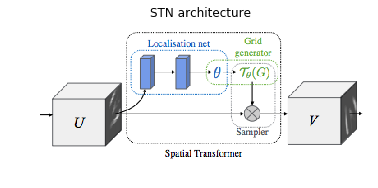

In [6]:
# Depicting Spatial Transformer Networks
# STN has three main components: 
    # the localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhance the global accuracy.
    # the grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image
    # the sampler uses the parameters of transformer and applies it to the input image.

plt.figure()
plt.axis('off')
plt.title('STN architecture')
plt.imshow(io.imread('stn-arch.png'))
plt.show()

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # Spatial transformer loacalization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, 7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, 5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for 3*2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*3*3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10*3*3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x
    
    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net().to(device)

In [8]:
# Training the model
# The network is learning the classification task in a supervised way.
# In the same time the model is learning STN automatically in an end-to-end fashion.

optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%300==0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,batch_idx*len(data), len(train_loader.dataset),
                100*batch_idx/len(train_loader), loss.item()))
#
# A simple test procedure to measure STN performances on MNIST.
#

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max-log probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss/=len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100*correct/len(test_loader.dataset)))

In [9]:
# Visualizing the STN results
# now we will inspect the results of our learned visual attention mechanism.

def convert_image_np(inp):
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# we want to visualize the output of the spatial transformer layers after the training
# we visualize a batch of input images and the corresponding transformed batch using STN.

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        
        print('Input Tensor: ', input_tensor.shape)
        print('Transformed Input Tensor: ', transformed_input_tensor.shape)
        
        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))
        
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [10]:
for epoch in range(1, 21):
    train(epoch)
    test()

Train epoch: 1 [0/60000 (0%)]	Loss: 2.314833
Train epoch: 1 [19200/60000 (32%)]	Loss: 1.444293
Train epoch: 1 [38400/60000 (64%)]	Loss: 0.980196
Train epoch: 1 [57600/60000 (96%)]	Loss: 0.461277

Test set: Average loss: 0.4636, Accuracy: 8503/10000 (85.0300%)

Train epoch: 2 [0/60000 (0%)]	Loss: 0.809615
Train epoch: 2 [19200/60000 (32%)]	Loss: 0.453653
Train epoch: 2 [38400/60000 (64%)]	Loss: 0.273997
Train epoch: 2 [57600/60000 (96%)]	Loss: 0.254066

Test set: Average loss: 0.1858, Accuracy: 9393/10000 (93.9300%)

Train epoch: 3 [0/60000 (0%)]	Loss: 0.228878
Train epoch: 3 [19200/60000 (32%)]	Loss: 0.222569
Train epoch: 3 [38400/60000 (64%)]	Loss: 0.123369
Train epoch: 3 [57600/60000 (96%)]	Loss: 0.675312

Test set: Average loss: 0.1108, Accuracy: 9649/10000 (96.4900%)

Train epoch: 4 [0/60000 (0%)]	Loss: 0.257452
Train epoch: 4 [19200/60000 (32%)]	Loss: 0.351792
Train epoch: 4 [38400/60000 (64%)]	Loss: 0.158628
Train epoch: 4 [57600/60000 (96%)]	Loss: 0.113986

Test set: Average los

Input Tensor:  torch.Size([64, 1, 28, 28])
Transformed Input Tensor:  torch.Size([64, 1, 28, 28])


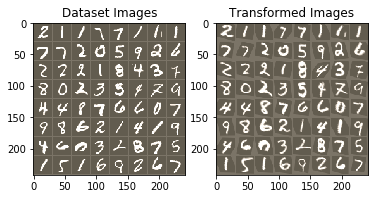

In [11]:
# Visualize the STN transformation on some input batch6
visualize_stn()
plt.ioff()
plt.show()